In [15]:
import os.path as osp

import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec

In [27]:
dataset = 'Cora'
path = osp.join(osp.dirname(osp.realpath('__file__')), '..', 'data', dataset)
dataset = Planetoid(path, dataset)
data = dataset[0]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=0)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

In [28]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [29]:
@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask],
                     max_iter=150)
    return acc

In [30]:
for epoch in range(1, 101):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')

Epoch: 01, Loss: 8.0886, Acc: 0.1750
Epoch: 02, Loss: 6.0431, Acc: 0.1960
Epoch: 03, Loss: 4.9352, Acc: 0.2190
Epoch: 04, Loss: 4.1229, Acc: 0.2430
Epoch: 05, Loss: 3.4782, Acc: 0.2750
Epoch: 06, Loss: 2.9446, Acc: 0.2990
Epoch: 07, Loss: 2.5324, Acc: 0.3320
Epoch: 08, Loss: 2.2090, Acc: 0.3690
Epoch: 09, Loss: 1.9442, Acc: 0.3960
Epoch: 10, Loss: 1.7308, Acc: 0.4150
Epoch: 11, Loss: 1.5607, Acc: 0.4530
Epoch: 12, Loss: 1.4247, Acc: 0.4740
Epoch: 13, Loss: 1.3128, Acc: 0.4940
Epoch: 14, Loss: 1.2256, Acc: 0.5130
Epoch: 15, Loss: 1.1565, Acc: 0.5490
Epoch: 16, Loss: 1.1000, Acc: 0.5720
Epoch: 17, Loss: 1.0531, Acc: 0.5870
Epoch: 18, Loss: 1.0192, Acc: 0.6050
Epoch: 19, Loss: 0.9920, Acc: 0.6240
Epoch: 20, Loss: 0.9683, Acc: 0.6380
Epoch: 21, Loss: 0.9493, Acc: 0.6470
Epoch: 22, Loss: 0.9326, Acc: 0.6540
Epoch: 23, Loss: 0.9203, Acc: 0.6720
Epoch: 24, Loss: 0.9098, Acc: 0.6680
Epoch: 25, Loss: 0.8994, Acc: 0.6690
Epoch: 26, Loss: 0.8912, Acc: 0.6640
Epoch: 27, Loss: 0.8846, Acc: 0.6680
E

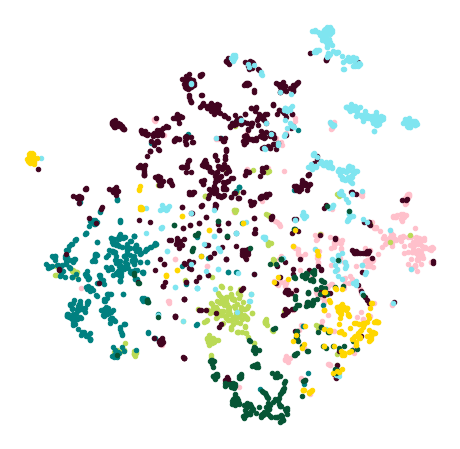

In [35]:
@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
    '#ffd700'
]


plot_points(colors)

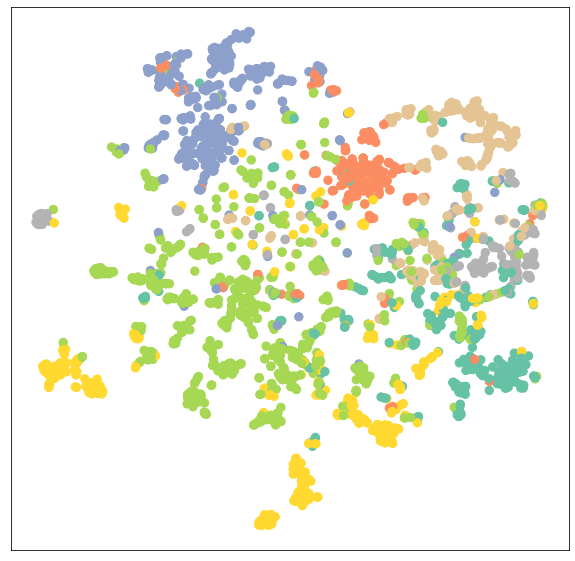

In [36]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()
    
labels = data.y.clone().detach().cpu()
out = model(torch.arange(data.num_nodes, device=device))
visualize(out, color=labels)